In [26]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance

In [27]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

In [43]:
########################   读取数据  #########################################
sheet = pd.read_excel('data_input/中国10债Non-Trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet.set_index('Date', inplace=True) 
full_date_range = pd.date_range(start=sheet.index.min(), end=sheet.index.max()+pd.Timedelta(days=60), freq='D') 
sheet = sheet.reindex(full_date_range)
# 有月度数据 所以 数据 处理逻辑 就是 全部填充 然后再变成 工作日数据
#############  处理缺失值 ##############
fill_methods = {
    '10年期美国国债收益率80日环差': 'interpolate',  # 日度数据
    '南华工业品指数80日环比':'interpolate', #日度数据
    '新增人民币贷款/中长期同差':'interpolate',  # 月度数据
    'M2同比': 'interpolate', # 月度数据
    'M1同比': 'interpolate', # 月度数据
    'DR007利率/15DMA': 'interpolate', #日度数据
    'CNH HIBOR/3M（同花顺）': 'interpolate', #日度数据
    '央行国债净买入额/1个月' : 'interpolate' #月度数据
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
last_day = sheet['中国10年期国债收益率Non-Trend/F0.2'].last_valid_index()
sheet = sheet.reset_index().rename(columns={'index': 'Date'})
########## 只保留工作日数据(周一到周五) ##########
sheet = sheet[sheet['Date'].dt.dayofweek < 5]
sheet_daily = sheet.copy()
########################   因子处理  #########################################
sheet_daily['10年期美国国债收益率80日环差_提前80天'] = sheet_daily['10年期美国国债收益率80日环差'].shift(80)
sheet_daily['南华工业品指数80日环比_提前55天'] = sheet_daily['南华工业品指数80日环比'].shift(55)
sheet_daily['新增人民币贷款/中长期同差_提前160天'] = sheet_daily['新增人民币贷款/中长期同差'].shift(160)
sheet_daily['M2同比_提前140天'] = sheet_daily['M2同比'].shift(140)
sheet_daily['M1同比_提前60天'] = sheet_daily['M1同比'].shift(60)
sheet_daily['DR007利率/15DMA_提前30天'] = sheet_daily['DR007利率/15DMA'].shift(30)
sheet_daily['CNH HIBOR/3M（同花顺）_提前60天'] = sheet_daily['CNH HIBOR/3M（同花顺）'].shift(60)

sheet_daily = sheet_daily[sheet_daily['Date'] >= '2020-08-01']  
############ 不同因子有效期不同  ##########
sheet_daily['10年期美国国债收益率80日环差_提前80天_2023-01-01之后'] = sheet_daily['10年期美国国债收益率80日环差_提前80天'].loc[sheet_daily['Date'] >= '2023-01-01']
sheet_daily['南华工业品指数80日环比_提前55天_2022-11-01之后'] = sheet_daily['南华工业品指数80日环比_提前55天'].loc[sheet_daily['Date'] >= '2022-11-01']
###### 逆序处理 ##########

sheet_daily['央行国债净买入额/1个月_逆序'] = reverse_column(sheet_daily, '央行国债净买入额/1个月')

#############  删除预测指标最后一天之前 为空值的一整行  ##############
sheet_daily = sheet_daily[(sheet_daily['Date'] > last_day) | sheet_daily['中国10年期国债收益率Non-Trend/F0.2'].notna()]

In [44]:
sheet_daily.columns

Index(['Date', '中国10年期国债收益率Non-Trend/F0.2', '10年期美国国债收益率80日环差', '南华工业品指数80日环比',
       '新增人民币贷款/中长期同差', 'M2同比', 'M1同比', 'DR007利率/15DMA', 'CNH HIBOR/3M（同花顺）',
       '央行国债净买入额/1个月', '10年期美国国债收益率80日环差_提前80天', '南华工业品指数80日环比_提前55天',
       '新增人民币贷款/中长期同差_提前160天', 'M2同比_提前140天', 'M1同比_提前60天',
       'DR007利率/15DMA_提前30天', 'CNH HIBOR/3M（同花顺）_提前60天',
       '10年期美国国债收益率80日环差_提前80天_2023-01-01之后',
       '南华工业品指数80日环比_提前55天_2022-11-01之后', '央行国债净买入额/1个月_逆序'],
      dtype='object')

In [45]:
sheet_daily.head()

,Date,中国10年期国债收益率Non-Trend/F0.2,10年期美国国债收益率80日环差,南华工业品指数80日环比,新增人民币贷款/中长期同差,M2同比,M1同比,DR007利率/15DMA,CNH HIBOR/3M（同花顺）,央行国债净买入额/1个月,10年期美国国债收益率80日环差_提前80天,南华工业品指数80日环比_提前55天,新增人民币贷款/中长期同差_提前160天,M2同比_提前140天,M1同比_提前60天,DR007利率/15DMA_提前30天,CNH HIBOR/3M（同花顺）_提前60天,10年期美国国债收益率80日环差_提前80天_2023-01-01之后,南华工业品指数80日环比_提前55天_2022-11-01之后,央行国债净买入额/1个月_逆序
10443,2020-08-03,-0.1132,-0.21,0.1641,3945.612903,10.670968,7.006452,2.1468,2.7396,NaN,-1.13,-0.1237,3092.032258,8.506452,5.961290,1.939600,2.2856,NaN,NaN,NaN
10444,2020-08-04,-0.1148,-0.21,0.1521,3947.483871,10.661290,7.041935,2.1476,2.8000,NaN,-1.13,-0.1134,3173.903226,8.496774,6.003226,1.979600,2.2370,NaN,NaN,NaN
10445,2020-08-05,-0.0834,-0.21,0.1468,3949.354839,10.651613,7.077419,2.1384,2.7848,NaN,-1.29,-0.1074,3255.774194,8.487097,6.045161,1.991200,2.2873,NaN,NaN,NaN
10446,2020-08-06,-0.0760,-0.21,0.1406,3951.225806,10.641935,7.112903,2.1222,2.8340,NaN,-1.31,-0.0989,3337.645161,8.477419,6.087097,1.992675,2.3736,NaN,NaN,NaN
10447,2020-08-07,-0.0736,-0.06,0.1284,3953.096774,10.632258,7.148387,2.1196,2.8531,NaN,-1.27,-0.1209,3419.516129,8.467742,6.129032,1.994150,2.2873,NaN,NaN,NaN


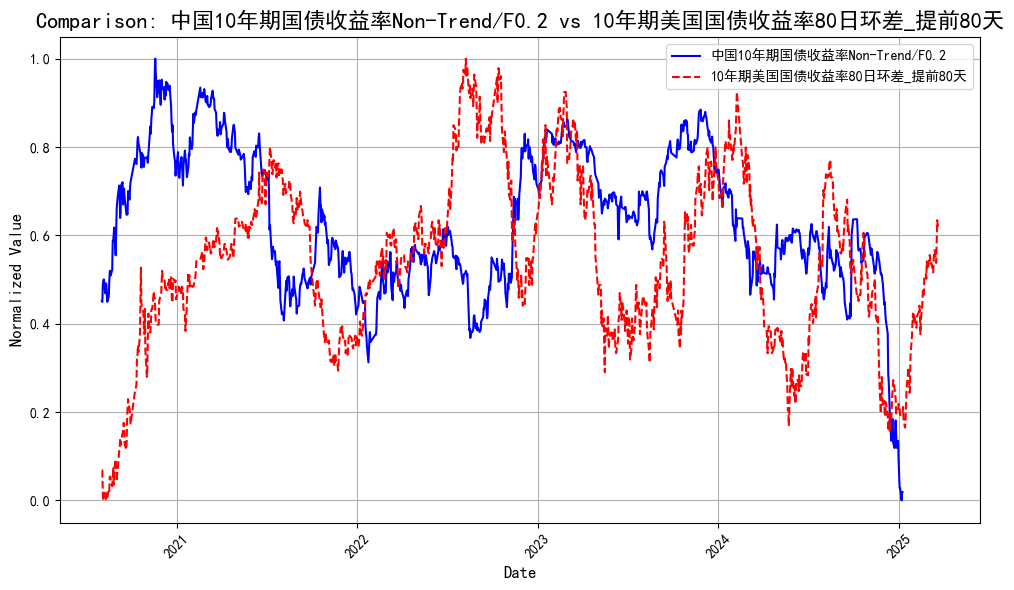

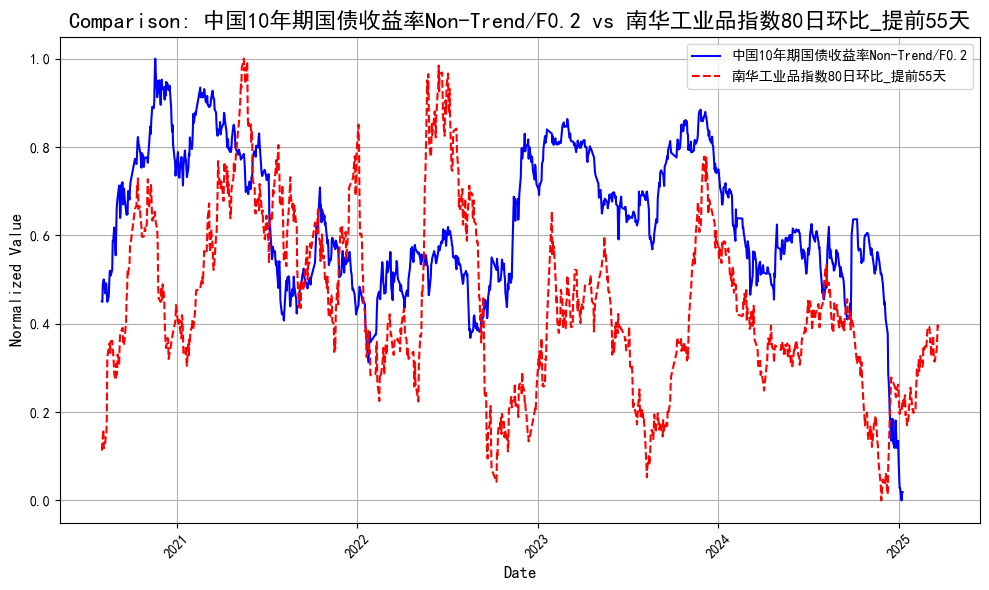

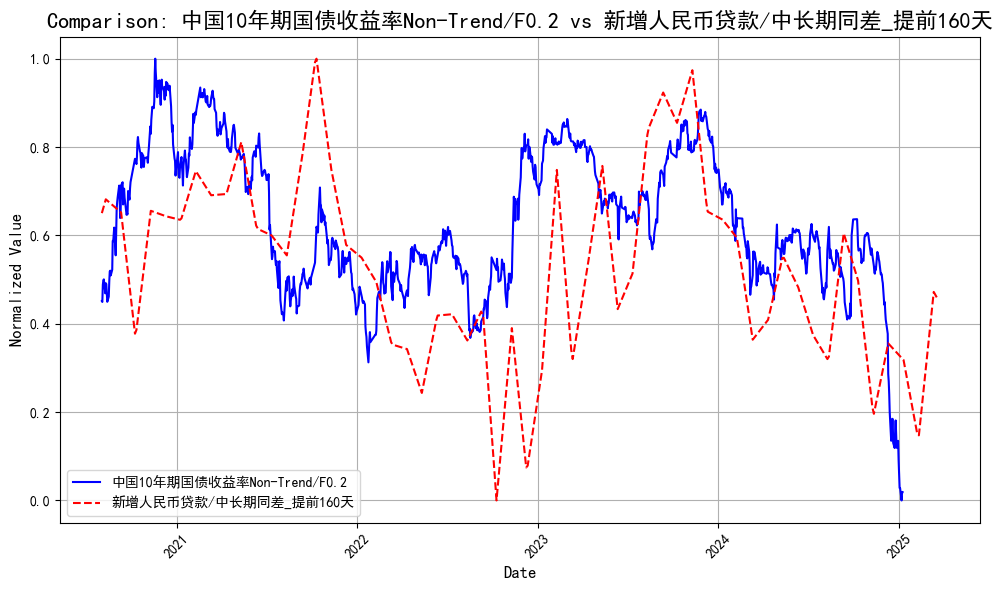

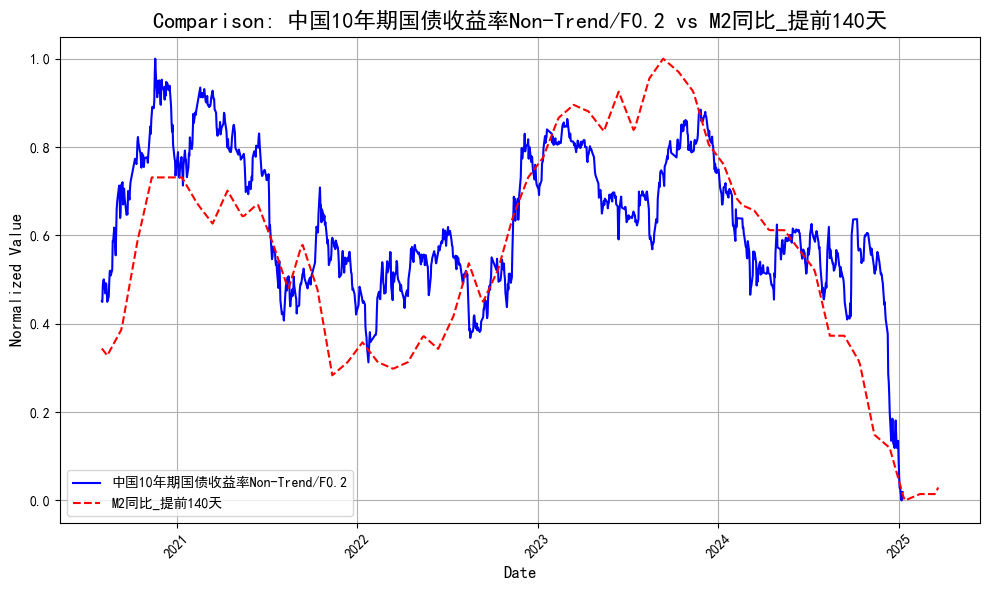

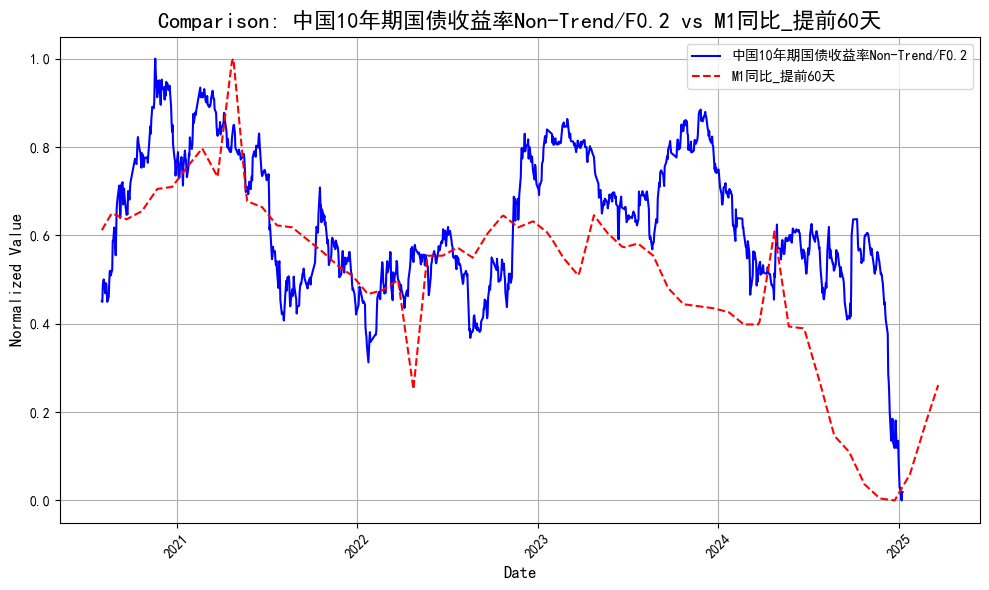

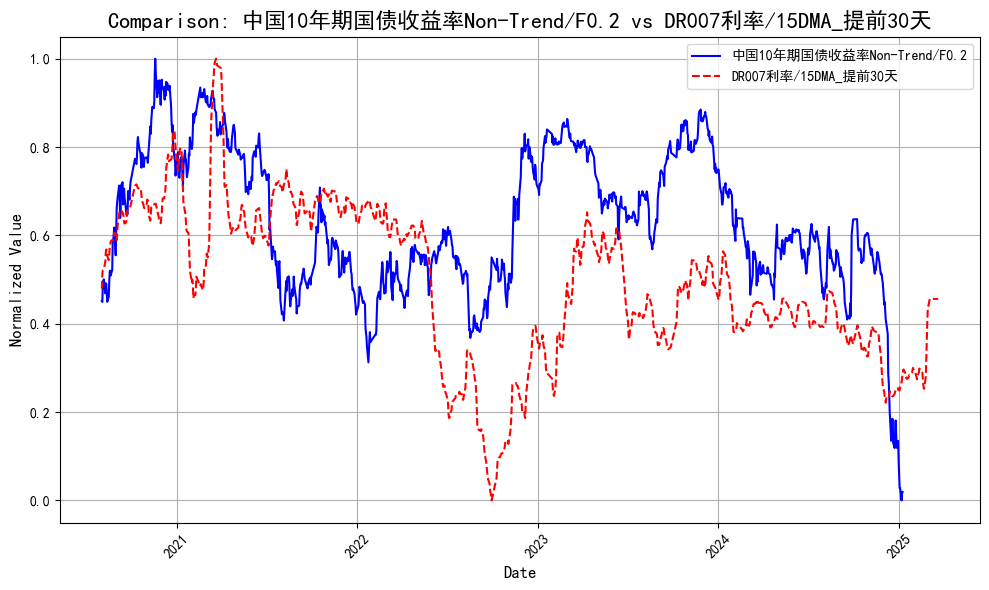

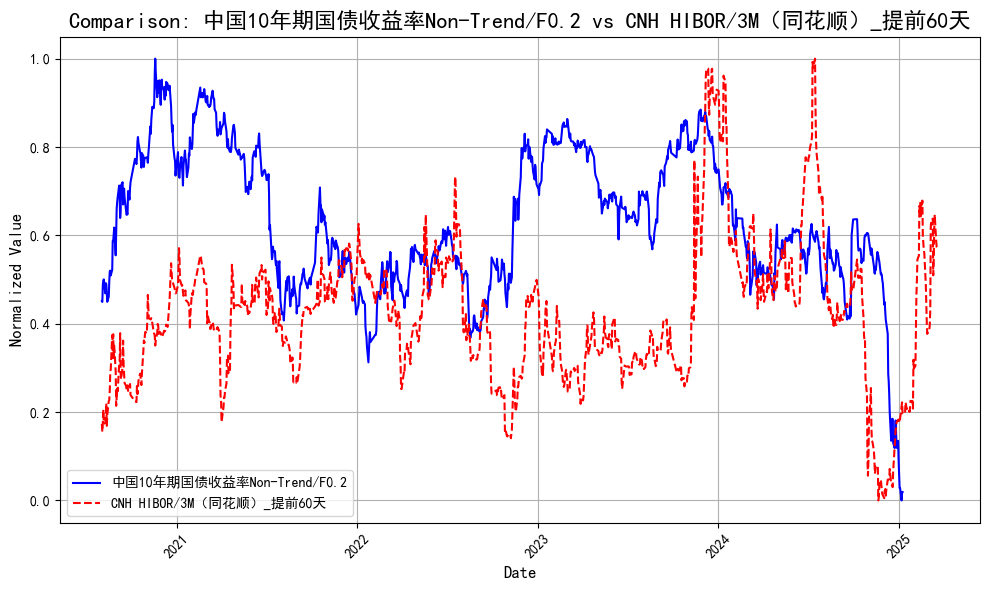

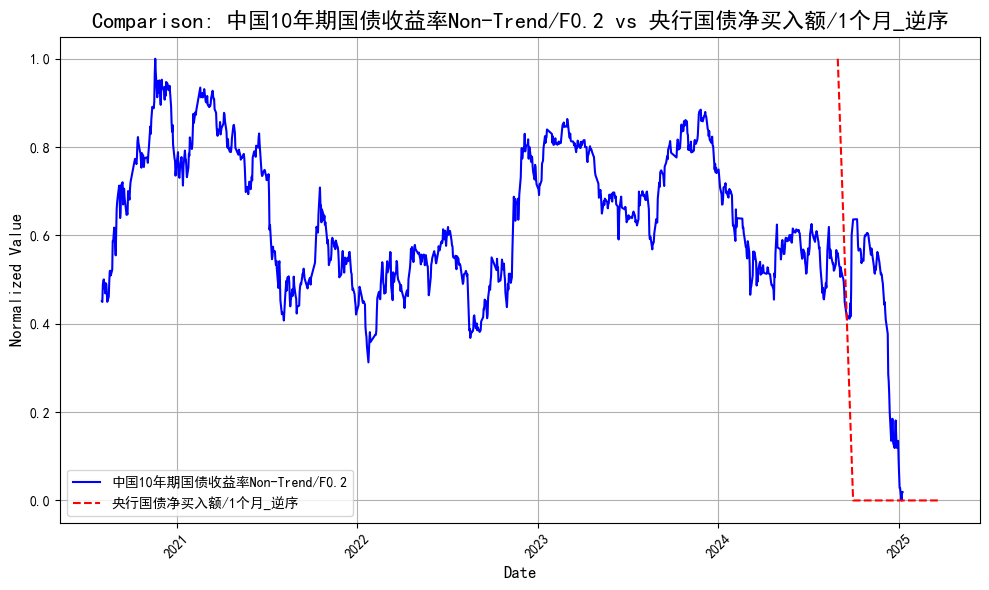

In [47]:
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='中国10年期国债收益率Non-Trend/F0.2', 
    compare_cols=[ '10年期美国国债收益率80日环差_提前80天','南华工业品指数80日环比_提前55天',
                  '新增人民币贷款/中长期同差_提前160天','M2同比_提前140天','M1同比_提前60天',
                  'DR007利率/15DMA_提前30天','CNH HIBOR/3M（同花顺）_提前60天','央行国债净买入额/1个月_逆序']
)

In [48]:
# 划分训练集、测试集和未来数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day]
test_period = 40
test_data = train_data[-test_period:]  
train_data = train_data[:-test_period]  
future_data = sheet_daily[sheet_daily['Date'] > last_day]

feature_columns = [
    '10年期美国国债收益率80日环差_提前80天',
    '南华工业品指数80日环比_提前55天',
    '新增人民币贷款/中长期同差_提前160天',
    'M2同比_提前140天',
    'M1同比_提前60天',
    'DR007利率/15DMA_提前30天',
    'CNH HIBOR/3M（同花顺）_提前60天',
    '央行国债净买入额/1个月_逆序'
]


# 准备训练、测试和未来数据的输入和输出
X_train = train_data[feature_columns]
y_train = train_data['中国10年期国债收益率Non-Trend/F0.2']

X_test = test_data[feature_columns]
y_test = test_data['中国10年期国债收益率Non-Trend/F0.2']

X_future = future_data[feature_columns]

In [49]:
# 设置参数以减少过拟合
model = XGBRegressor(
    max_depth=4,           # 减小树的深度
    learning_rate=0.05,    # 较小的学习率
    n_estimators=100,      # 适中的树的数量
    min_child_weight=3,    # 增加一点以减少过拟合
    subsample=0.8,         # 每次训练使用80%的样本
    colsample_bytree=0.8,  # 每棵树使用80%的特征
    reg_alpha=0.1,         # L1正则化
    reg_lambda=1.0         # L2正则化
)   

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_future_pred = model.predict(X_future)

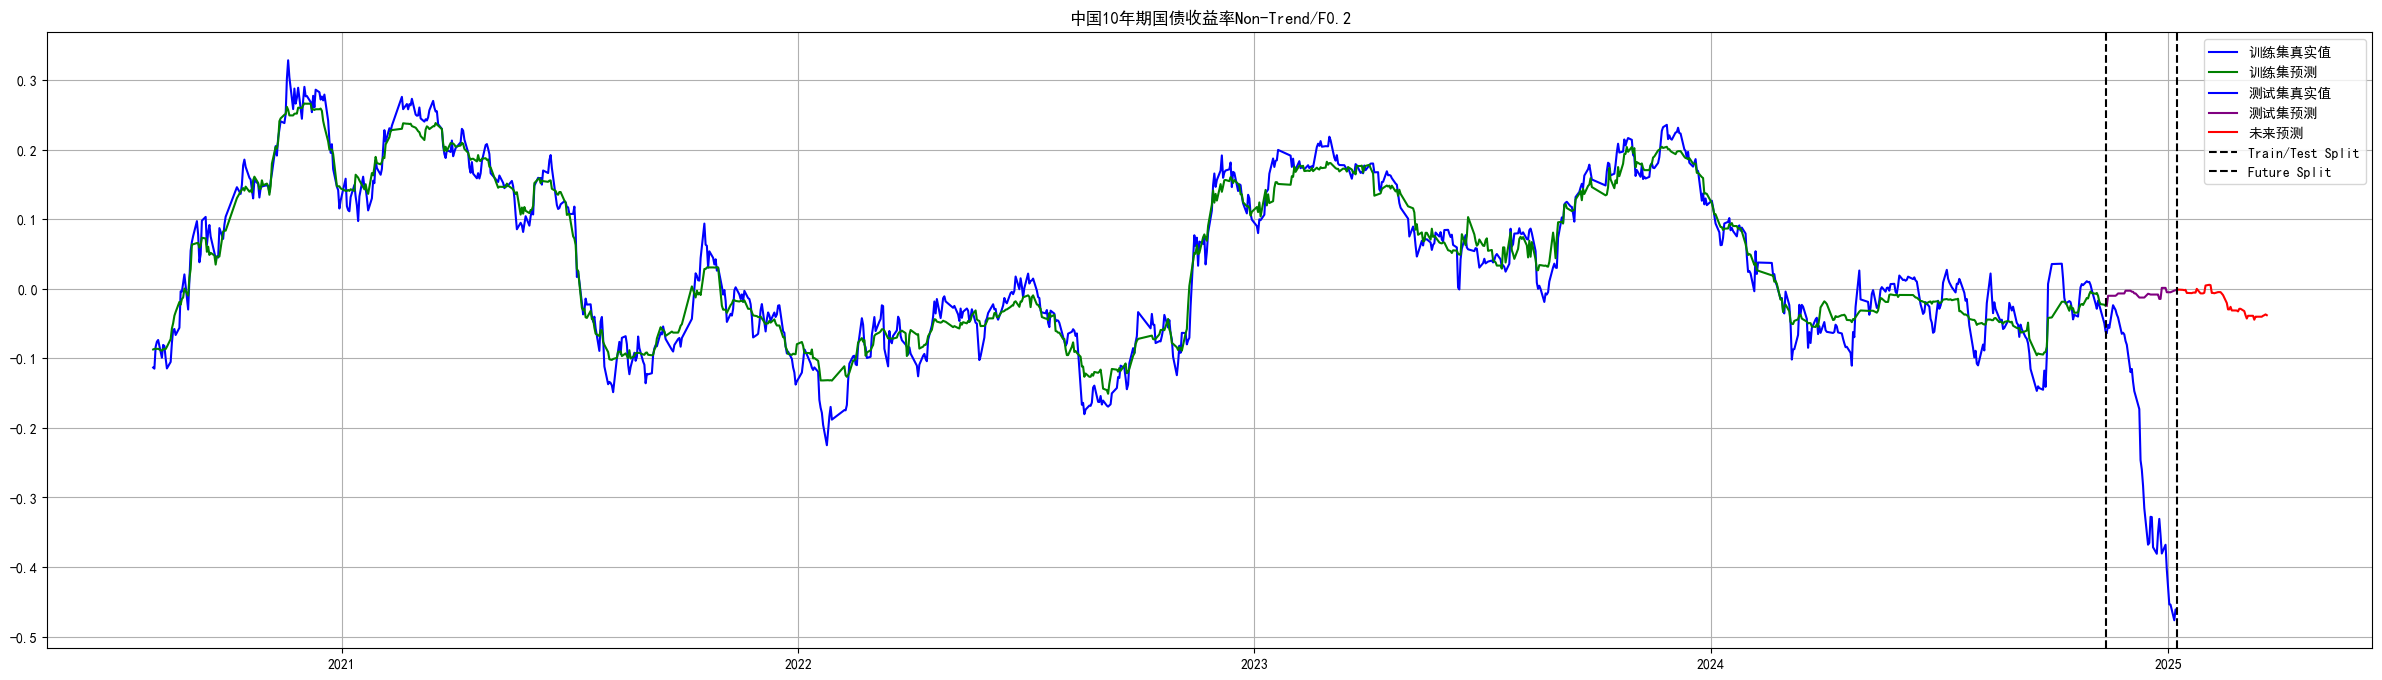

In [50]:
plt.figure(figsize=(30, 8))
plt.plot(train_data['Date'], y_train, label='训练集真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集真实值', color='blue')
plt.plot(test_data['Date'], y_test_pred, label='测试集预测', color='purple')
plt.plot(future_data['Date'], y_future_pred, label='未来预测', color='red')

plt.axvline(x=train_data['Date'].iloc[-1], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')


plt.title('中国10年期国债收益率Non-Trend/F0.2')
plt.legend()
plt.grid(True)
plt.show()


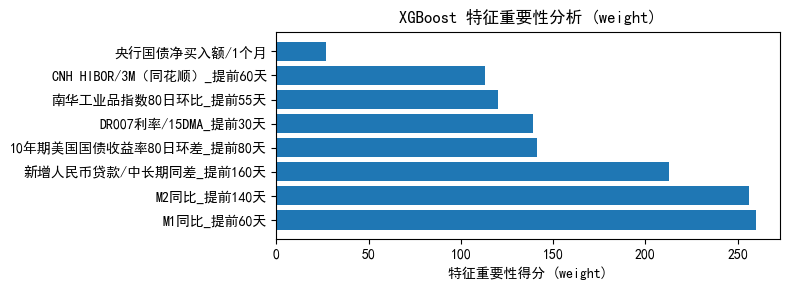

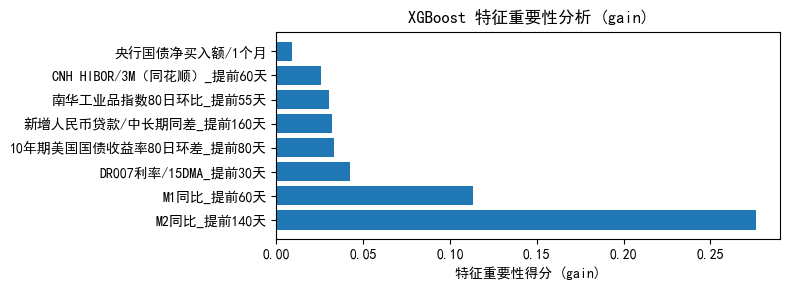

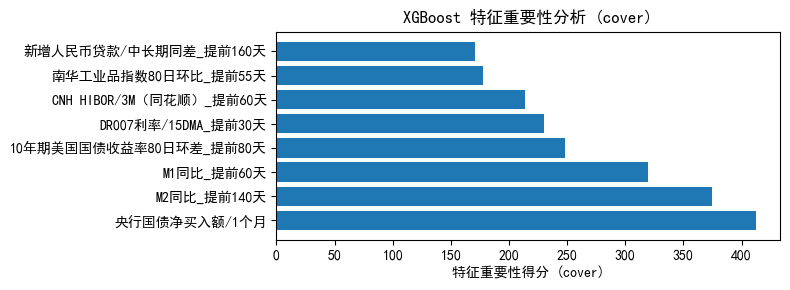

In [35]:
booster = model.get_booster()

# 将 f0, f1 等映射到实际的特征名称
feature_names = X_train.columns  # 假设这是您的特征名称列表
feature_map = {f'f{i}': name for i, name in enumerate(feature_names)}

# 绘制 weight、gain 和 cover 的特征重要性图
plot_feature_importance(booster, 'weight', feature_map, 'XGBoost 特征重要性分析 (weight)', '特征重要性得分 (weight)')
plot_feature_importance(booster, 'gain', feature_map, 'XGBoost 特征重要性分析 (gain)', '特征重要性得分 (gain)')
plot_feature_importance(booster, 'cover', feature_map, 'XGBoost 特征重要性分析 (cover)', '特征重要性得分 (cover)')

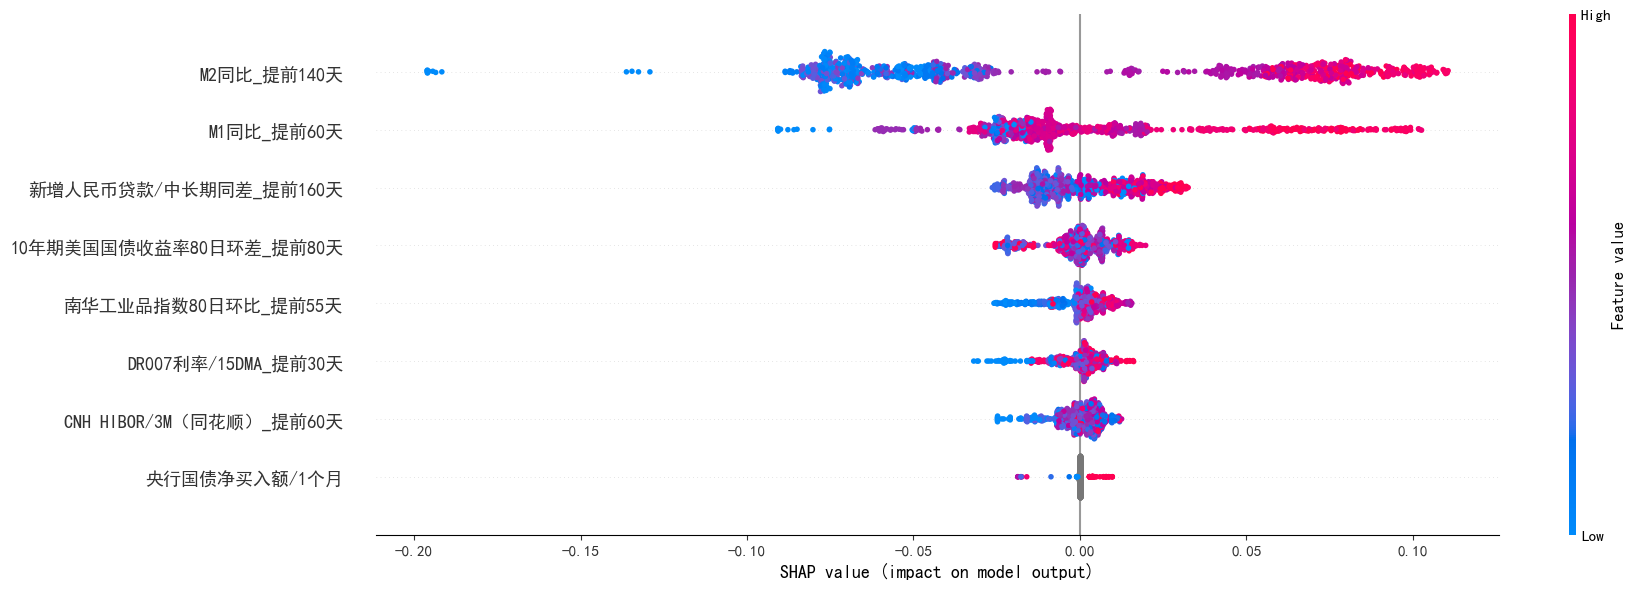

<Figure size 3000x800 with 0 Axes>

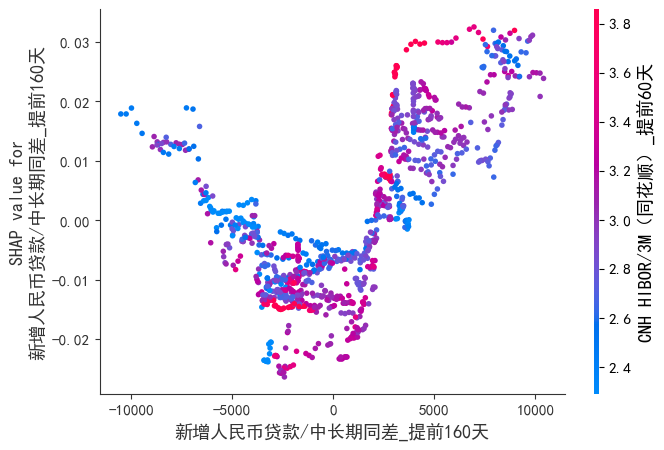

In [36]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# 确保 X_train_scaled 和 X_train 是 DataFrame
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)

# 创建 SHAP Explainer
explainer = shap.Explainer(model, X_train_df)

# 计算 SHAP 值
shap_values = explainer(X_train_df)

# 提取 SHAP 值数组
shap_values_array = shap_values.values

# 绘制 SHAP Summary Plot
shap.summary_plot(
    shap_values_array,
    X_train,
    feature_names=X_train.columns,
    plot_size=(18, 6)  # 控制图形比例
)


# 绘制单个特征的依赖图
plt.figure(figsize=(30, 8))  # 增加图表宽度
shap.dependence_plot(
    '新增人民币贷款/中长期同差_提前160天',
    shap_values_array,
    X_train,
    feature_names=X_train.columns
)